# Unsupervised Learning Trading Strategy
- Download/Load SP500 stocks prices data.
- Calculate different features and indicators on each stock.
- Aggregate on monthly level and filter top 150 most liquid stocks.
- Calculate Monthly Returns for different time-horizons.
- Download Fama-French Factors and Calculate Rolling Factor Betas.
- For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.
- For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization.
- Visualize Portfolio returns and compare to SP500 returns.

## 1. Download/Load SP500 stocks prices data.

In [96]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xlsxwriter
import math
import yfinance as yf
import pandas_ta as ta
import datetime as dt
import warnings
from yahooquery import Ticker

warnings.filterwarnings('ignore')

In [127]:
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')
symbols_list = sp500['Symbol'].unique().tolist()

symbols_list.remove('VLTO')

symbols_string = " ".join(str(element) for element in symbols_list)
tickers = yf.Tickers(symbols_string)

end_date = '2024-01-04'
start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)

# tickers = Ticker(symbols_string, asynchronous=True)

# Default period = ytd, interval = 1d

df = yf.download(tickers=symbols_list,
                 start=start_date,
                 end=end_date).stack()

df


[*********************100%%**********************]  502 of 502 completed


Adj Close       Close        High         Low        Open  \
Date                                                                          
2016-01-06 A      38.171921   40.730000   40.990002   40.049999   40.240002   
           AAL    39.401268   41.230000   41.700001   40.000000   40.049999   
           AAPL   22.919146   25.174999   25.592501   24.967501   25.139999   
           ABBV   40.615276   57.380001   57.560001   56.180000   56.369999   
           ABT    36.637783   42.560001   42.980000   42.209999   42.310001   
...                     ...         ...         ...         ...         ...   
2024-01-03 YUM   129.100006  129.100006  130.539993  128.940002  130.059998   
           ZBH   120.470001  120.470001  121.300003  119.720001  120.930000   
           ZBRA  252.520004  252.520004  265.549988  252.380005  264.119995   
           ZION   42.000000   42.000000   43.439999   41.860001   43.259998   
           ZTS   192.929993  192.929993  195.949997  192.800003  195.919998   

                      Volume  
Date                          
2016-01-06 A       2103600.0  
           AAL    12393800.0  
           AAPL  273829600.0  
           ABBV    8952700.0  
           ABT     5906000.0  
...                      ...  
2024-01-03 YUM     1483600.0  
           ZBH     2325500.0  
           ZBRA     404800.0  
           ZION    3048300.0  
           ZTS     1493000.0  

[994485 rows x 6 columns]

In [128]:
df.index.names = ['symbol', 'date']
df.columns = df.columns.str.lower()

df

adj close       close        high         low        open  \
symbol     date                                                               
2016-01-06 A      38.171921   40.730000   40.990002   40.049999   40.240002   
           AAL    39.401268   41.230000   41.700001   40.000000   40.049999   
           AAPL   22.919146   25.174999   25.592501   24.967501   25.139999   
           ABBV   40.615276   57.380001   57.560001   56.180000   56.369999   
           ABT    36.637783   42.560001   42.980000   42.209999   42.310001   
...                     ...         ...         ...         ...         ...   
2024-01-03 YUM   129.100006  129.100006  130.539993  128.940002  130.059998   
           ZBH   120.470001  120.470001  121.300003  119.720001  120.930000   
           ZBRA  252.520004  252.520004  265.549988  252.380005  264.119995   
           ZION   42.000000   42.000000   43.439999   41.860001   43.259998   
           ZTS   192.929993  192.929993  195.949997  192.800003  195.919998   

                      volume  
symbol     date               
2016-01-06 A       2103600.0  
           AAL    12393800.0  
           AAPL  273829600.0  
           ABBV    8952700.0  
           ABT     5906000.0  
...                      ...  
2024-01-03 YUM     1483600.0  
           ZBH     2325500.0  
           ZBRA     404800.0  
           ZION    3048300.0  
           ZTS     1493000.0  

[994485 rows x 6 columns]

## 2. Calculate features and technical indicators for each stock.

- Garman-Klass Volatility
- RSI
- Bollinger Bands
- ATR
- MACD
- Dollar Volume

In [129]:
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2 - (2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

df

adj close       close        high         low        open  \
symbol     date                                                               
2016-01-06 A      38.171921   40.730000   40.990002   40.049999   40.240002   
           AAL    39.401268   41.230000   41.700001   40.000000   40.049999   
           AAPL   22.919146   25.174999   25.592501   24.967501   25.139999   
           ABBV   40.615276   57.380001   57.560001   56.180000   56.369999   
           ABT    36.637783   42.560001   42.980000   42.209999   42.310001   
...                     ...         ...         ...         ...         ...   
2024-01-03 YUM   129.100006  129.100006  130.539993  128.940002  130.059998   
           ZBH   120.470001  120.470001  121.300003  119.720001  120.930000   
           ZBRA  252.520004  252.520004  265.549988  252.380005  264.119995   
           ZION   42.000000   42.000000   43.439999   41.860001   43.259998   
           ZTS   192.929993  192.929993  195.949997  192.800003  195.919998   

                      volume  garman_klass_vol  
symbol     date                                 
2016-01-06 A       2103600.0         -0.000806  
           AAL    12393800.0          0.000763  
           AAPL  273829600.0         -0.002999  
           ABBV    8952700.0         -0.041212  
           ABT     5906000.0         -0.007841  
...                      ...               ...  
2024-01-03 YUM     1483600.0          0.000055  
           ZBH     2325500.0          0.000080  
           ZBRA     404800.0          0.000515  
           ZION    3048300.0          0.000349  
           ZTS     1493000.0          0.000040  

[994485 rows x 7 columns]

<Axes: xlabel='symbol'>

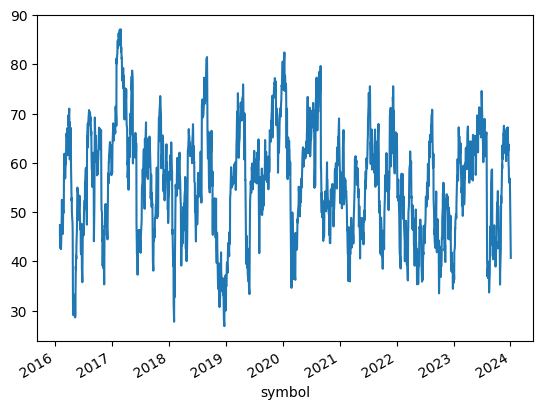

In [130]:
df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: ta.rsi(close=x, length = 20))

df.xs('AAPL', level=1)['rsi'].plot()

In [131]:
df = df.groupby(level='symbol').filter(lambda x: len(x) >= 20)

In [132]:
df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: ta.bbands(close=np.log1p(x), length=20).iloc[:,0])

df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: ta.bbands(close=np.log1p(x), length=20).iloc[:,1])

df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

In [133]:
df

adj close       close        high         low        open  \
symbol     date                                                               
2016-01-06 A      38.171921   40.730000   40.990002   40.049999   40.240002   
           AAL    39.401268   41.230000   41.700001   40.000000   40.049999   
           AAPL   22.919146   25.174999   25.592501   24.967501   25.139999   
           ABBV   40.615276   57.380001   57.560001   56.180000   56.369999   
           ABT    36.637783   42.560001   42.980000   42.209999   42.310001   
...                     ...         ...         ...         ...         ...   
2024-01-03 YUM   129.100006  129.100006  130.539993  128.940002  130.059998   
           ZBH   120.470001  120.470001  121.300003  119.720001  120.930000   
           ZBRA  252.520004  252.520004  265.549988  252.380005  264.119995   
           ZION   42.000000   42.000000   43.439999   41.860001   43.259998   
           ZTS   192.929993  192.929993  195.949997  192.800003  195.919998   

                      volume  garman_klass_vol        rsi    bb_low    bb_mid  \
symbol     date                                                                 
2016-01-06 A       2103600.0         -0.000806        NaN       NaN       NaN   
           AAL    12393800.0          0.000763        NaN       NaN       NaN   
           AAPL  273829600.0         -0.002999        NaN       NaN       NaN   
           ABBV    8952700.0         -0.041212        NaN       NaN       NaN   
           ABT     5906000.0         -0.007841        NaN       NaN       NaN   
...                      ...               ...        ...       ...       ...   
2024-01-03 YUM     1483600.0          0.000055  54.360388  4.828101  4.864795   
           ZBH     2325500.0          0.000080  63.340087  4.755974  4.787581   
           ZBRA     404800.0          0.000515  52.714502  5.428569  5.554209   
           ZION    3048300.0          0.000349  56.397718  3.629474  3.760402   
           ZTS     1493000.0          0.000040  58.881491  5.204421  5.266937   

                  bb_high  
symbol     date            
2016-01-06 A          NaN  
           AAL        NaN  
           AAPL       NaN  
           ABBV       NaN  
           ABT        NaN  
...                   ...  
2024-01-03 YUM   4.901488  
           ZBH   4.819187  
           ZBRA  5.679848  
           ZION  3.891330  
           ZTS   5.329454  

[994485 rows x 11 columns]

In [134]:
ta.atr(high=df['high'], low=df['low'],close=df['close'],length=14)

symbol      date
2016-01-06  A              NaN
            AAL            NaN
            AAPL           NaN
            ABBV           NaN
            ABT            NaN
                       ...    
2024-01-03  YUM      98.963353
            ZBH      92.564542
            ZBRA     96.315645
            ZION    104.483099
            ZTS     108.016449
Name: ATRr_14, Length: 994485, dtype: float64

In [136]:
def compute_atr(stock_data):
    atr = ta.atr(high=stock_data['high'], low=stock_data['low'],close=stock_data['close'],length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

In [137]:
df

adj close       close        high         low        open  \
symbol     date                                                               
2016-01-06 A      38.171921   40.730000   40.990002   40.049999   40.240002   
           AAL    39.401268   41.230000   41.700001   40.000000   40.049999   
           AAPL   22.919146   25.174999   25.592501   24.967501   25.139999   
           ABBV   40.615276   57.380001   57.560001   56.180000   56.369999   
           ABT    36.637783   42.560001   42.980000   42.209999   42.310001   
...                     ...         ...         ...         ...         ...   
2024-01-03 YUM   129.100006  129.100006  130.539993  128.940002  130.059998   
           ZBH   120.470001  120.470001  121.300003  119.720001  120.930000   
           ZBRA  252.520004  252.520004  265.549988  252.380005  264.119995   
           ZION   42.000000   42.000000   43.439999   41.860001   43.259998   
           ZTS   192.929993  192.929993  195.949997  192.800003  195.919998   

                      volume  garman_klass_vol        rsi    bb_low    bb_mid  \
symbol     date                                                                 
2016-01-06 A       2103600.0         -0.000806        NaN       NaN       NaN   
           AAL    12393800.0          0.000763        NaN       NaN       NaN   
           AAPL  273829600.0         -0.002999        NaN       NaN       NaN   
           ABBV    8952700.0         -0.041212        NaN       NaN       NaN   
           ABT     5906000.0         -0.007841        NaN       NaN       NaN   
...                      ...               ...        ...       ...       ...   
2024-01-03 YUM     1483600.0          0.000055  54.360388  4.828101  4.864795   
           ZBH     2325500.0          0.000080  63.340087  4.755974  4.787581   
           ZBRA     404800.0          0.000515  52.714502  5.428569  5.554209   
           ZION    3048300.0          0.000349  56.397718  3.629474  3.760402   
           ZTS     1493000.0          0.000040  58.881491  5.204421  5.266937   

                  bb_high       atr  
symbol     date                      
2016-01-06 A          NaN       NaN  
           AAL        NaN       NaN  
           AAPL       NaN       NaN  
           ABBV       NaN       NaN  
           ABT        NaN       NaN  
...                   ...       ...  
2024-01-03 YUM   4.901488 -0.079818  
           ZBH   4.819187 -1.050234  
           ZBRA  5.679848  0.006201  
           ZION  3.891330  0.300673  
           ZTS   5.329454  0.420384  

[994485 rows x 12 columns]